**Human-In-Loop Dynamic Recommendations**

Imagine a scenario where users interact with a system to get product recommendations (movies ,books). This isn't a static, one-size-fits-all approach. User needs are nuanced and require dynamic adjustments. 
For instance, a user asking for "a good movie" might actually be looking for a horror film, a comedy, or something entirely different. or asking for a book, etc.

To handle such complexity, we need a system that:

- **Understands User Intent:** Interprets the user's request and identifies their preferences.

- **Chooses the Right Tool:** Dynamically selects tools based on the user's preference (e.g., a movie recommender vs. a book recommender).

- **Human-In-Loop:** Ask user approval before proceeding to execute tool

- **Orchestrates the Flow:** Manages the interaction between different components of the system.

- **Delivers a Final Recommendation:** Presents the user with a relevant product.

In [1]:
from typing import Annotated, Sequence, TypedDict, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate
from display_graph import display_graph
from pydantic import BaseModel, ValidationError, Field
import os, sys, json
import logging
import asyncio
from langgraph.checkpoint.memory import MemorySaver

In [2]:
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)


**Defining the State**

At the core of any LangGraph application is the concept of state. This state is essentially the memory of your application, keeping track of the current situation. In our example, we define **RecommendationState** using Python's **TypedDict**:

In [3]:
class RecommendationState(TypedDict):
    user_id: str  # User id
    preference: str  # User's preference
    recommendation: str  #  product recommendation
    messages: Annotated[Sequence[BaseMessage], add_messages]


**Modeling User Preferences with Pydantic**

To handle the specific preferences of our users, we define data models using Pydantic. This provides validation and a structured way to extract and manage user preferences. Let's see it for MoviePreference and BookPreference.

Pydantic is a library for data validation and settings management using Python type hints. It allows us to define clear structures for our data, enforce type checks, and get easy access to the data through Python attributes.

- **class MoviePreference(BaseModel) and BookPreference(BaseModel):** This line declares a class called MoviePreference that inherits from Pydantic's BaseModel. This inheritance gives MoviePreference all the capabilities of Pydantic models, such as data validation, serialization, and deserialization.

- **Attributes as Fields:** 
Inside the class, we define attributes (also known as fields):

- **MoviePreference.model_rebuild():**
It ensures that the model's schema (its structure and type information) is fully updated, which is especially important if you have inheritance or complex field definitions.




**Benefits of Pydantic**

- Data Validation: 

    Pydantic ensures that the data received conforms to the expected types and constraints. If the LLM or any other part of the system tries to use an incorrect data type or miss a required field, Pydantic will raise a ValidationError, preventing errors downstream.

- Structured Data: 

    It provides a clear structure for user preferences, making the code easier to read, maintain, and debug. Instead of working with unstructured data, we have well-defined objects with access via properties (e.g. movie_preference.horror instead of movie_preference["horror"]).

- Automatic Type Conversion: 

    Pydantic can automatically convert data types when necessary, making it easier to work with data from different sources.

- Serialization and Deserialization: 

    Pydantic facilitates the easy conversion of these models to and from formats like JSON which is very helpful for passing model data between different parts of the system.

- Enhanced Development Experience: 

    Pydantic's descriptive errors make it easier to identify and fix data issues.

**Integration with LangGraph:**

In the context of our LangGraph application, these models will be used to parse output from the LLM. When the LLM returns preference data for the user, this data is parsed into MoviePreference or BookPreference object. By using these structured models, we make the LangGraph logic easier to manage.

In [4]:
# Define the MoviePreference model
class MoviePreference(BaseModel):
    horror: str = Field(..., description="User's preference for horror movies")
    comedy: str = Field(..., description="User's preference for comedy movies")
    fiction: str = Field(..., description="User's preference for fiction movies")
    action: str = Field(..., description="User's preference for action movies")
    none: str = Field(..., description="No preference or other")


# Call model_rebuild() to finalize the model
MoviePreference.model_rebuild()


# Define the BookPreference model
class BookPreference(BaseModel):
    science: str = Field(..., description="User's preference for science book")
    technology: str = Field(..., description="User's preference for technology book")
    fiction: str = Field(..., description="User's preference for fiction book")
    none: str = Field(..., description="No preference or other")


# Call model_rebuild() to finalize the model
BookPreference.model_rebuild()


It initializes an instance of the ChatOllama class.

model="llama3.1:8b": Specifies which Ollama model to load and use. 

In [5]:
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage
from langchain_ollama.chat_models import ChatOllama

# Initialize the LLM
llm = ChatOllama(model="llama3.1:8b")


The ***recommend_movie*** and  ***recommend_books*** **tool function** are responsible for:

- Checking if user preference is already available. If not then extract the preference using getUserPreference function.

- Logging the current preference.

- Fetching an appropriate recommendation from a static database.

- Updating the recommendation in the state.

- Returning the modified state.

In [6]:
def getUserPreference(state: RecommendationState, product: str):
    logging.info(f"Checking user's preference for {product}.... ")
    user_query = state["messages"][0].content
    prompt = (
        f"For a give user query suggest user's {product} preference. Suggest atleast one from available option with value 'high' and rest with 'low'. \
             User Query : {user_query}"
    )

    preference_prompt = ChatPromptTemplate.from_template(prompt)

    user_preference = preference_prompt | llm.with_structured_output(
        MoviePreference if product == "movie" else BookPreference
    )
    try:
        output = user_preference.invoke(state)
        high_preference = [
            key for key, value in output.model_dump().items() if value == "high"
        ]
        user_movie_preference = high_preference[0] if high_preference else "none"
    except ValidationError as exc:
        user_movie_preference = "none"
        logging.error("Error in user preference : `%s`", exc.errors())

    return {"preference": user_movie_preference}


@tool
def recommend_movie(state: RecommendationState):
    """Recommend a movie based on the user's preferences."""

    if state["preference"] == "":
        user_preference = getUserPreference(state, "movie")
        state.update(user_preference)

    logging.info(
        "Step 3.1: executing recommend_movie for preference : `%s`", state["preference"]
    )
    product_db = {
        "horror": f"Recommandation for {state['preference']} movie is 'Dracula'",
        "comedy": f"Recommandation for {state['preference']} movie is 'Home Alone'",
        "fiction": f"Recommandation for {state['preference']} movie is 'Matrix'",
        "science": f"Recommandation for {state['preference']} movie is 'Interstellar'",
        "action": f"Recommandation for {state['preference']} movie is 'Terminator'",
    }

    state["recommendation"] = product_db.get(state["preference"], "No recommendation")

    return state


# Tool function: Recommend a product based on the user's preference
@tool
def recommend_book(state: RecommendationState):
    """Recommend a book based on the user's preferences."""

    if state["preference"] == "":
        user_preference = getUserPreference(state, "book")
        state.update(user_preference)

    logging.info(
        "Step 3.1 : executing recommend_book for preference: `%s`", state["preference"]
    )
    product_db = {
        "science": f"Recommandation for {state['preference']} book is 'A Brief History of Time' by Stephen Hawking.",
        "technology": f"Recommandation for {state['preference']} book is 'The Innovators' by Walter Isaacson.",
        "fiction": f"Recommandation for {state['preference']} book is 'The Alchemist' by Paulo Coelho.",
    }

    state["recommendation"] = product_db.get(state["preference"], "No recommendation")

    return state


In [7]:
"""
- Combines multiple tool function in a python list.
- Registers those tools with LLM for making it accessible to LLM using bind_tools.
- Creates a lookup dictionary for those tools based on their name.
"""
tools = [recommend_book, recommend_movie]
llm = llm.bind_tools(tools=tools)
tools_by_name = {tool.name: tool for tool in tools}





This module provides functions for handling product recommendations using a language model (LLM) and tools.


**Functions:**

- **tool_node(state: RecommendationState) -> RecommendationState:**
    Handles the invocation of tools for product recommendations based on the state.


- **call_model(state: RecommendationState, config: RunnableConfig) -> RecommendationState:**
    Processes user input and generates product recommendations using the LLM.


- **should_continue(state: RecommendationState) -> str:**
    Determines whether to continue with tool calling or end the process based on the state.


In [8]:
def tool_node(state: RecommendationState):
    logging.info("Step 3: Looping through available tools.... ")

    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_call["args"]["state"] = state
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        state.update(tool_result)
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result["recommendation"]),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    logging.info("tool recommendation  : `%s`", state["recommendation"])
    state["messages"] = outputs
    return state


# LLM reasoning node to process user input and generate product recommendations
def call_model(state: RecommendationState, config: RunnableConfig):
    logging.info("Step 1: calling model for below prompt.... ")

    if state["recommendation"] != "":
        logging.info(
            "No need to call model as recommendation is already provided : `%s`. ",
            state["recommendation"],
        )
        return state

    system_prompt = SystemMessage(
        content=f"You are a helpful assistant for recommending a product based on the user's preference."
    )

    # Convert messages to a serializable format
    formatted_messages = (
        [{"role": "system", "content": system_prompt.content}]
        + [
            {"role": "user", "content": msg.content}
            if isinstance(msg, HumanMessage)
            else {"role": "assistant", "content": msg.content}
            for msg in state["messages"]
        ]
        # + [{"role": "user", "content": state["preference"]}]
    )

    logging.info(formatted_messages)

    response = llm.invoke(formatted_messages, config)
    state["messages"] = [response]

    logging.info("Model suggest to call  : `%s` tool", response.tool_calls[0]["name"])
    return state


# Conditional function to determine whether to call the tool or end
def should_continue(state: RecommendationState):
    logging.info("Step 2: Checking condition to continue with tool calling or end.... ")

    if state["recommendation"] != "":
        logging.info("Proceed to END since recommendation is already provided.... ")
        return "end"
    else:
        logging.info(
            "continue with tool calling since no recommendation is provided yet.... "
        )
        return "continue"


**Build Graph**

- Graph Structure: This code defines the entire structure of our LangGraph workflow. It connects all the different nodes and specifies how the execution will flow.

- State Management: The graph uses StateGraph to allow the state object RecommendationState to be passed to different nodes for manipulation and decision making.

- Dynamic Execution: Conditional edges and tool function helps in building dynamic execution flow based on the user interaction.

- Modularity: Each node represents a discrete unit of functionality, making the workflow easier to understand and modify.

In [9]:
from langgraph.graph import StateGraph, END, START

workflow = StateGraph(RecommendationState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)
workflow.add_edge("tools", "agent")

# Compile the graph, ask for user approval before proceeding tool node
graph = workflow.compile(interrupt_before=["tools"], checkpointer=MemorySaver())


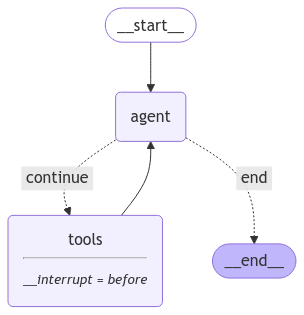

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


**Execution:**

To start execution, initialize the graph with initial state by providing the user input message. The graph execution is started by calling invoke method with initial state.


Either pass 'preference' in input otherwise agent will automatically extract preference based on user query

**Human in loop**

Enter yes/no at the top. 
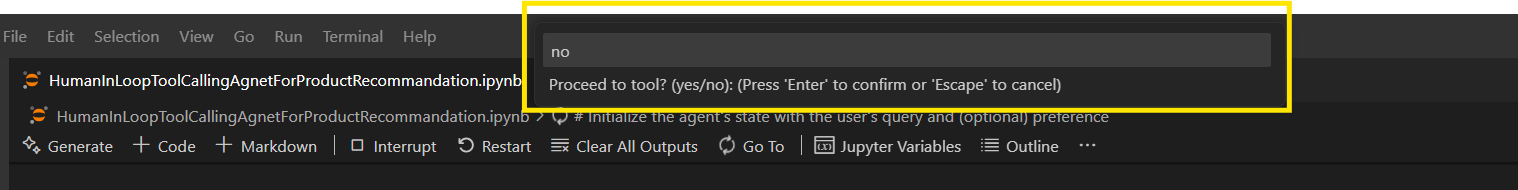

Example with human feedback 'no'

In [11]:
# Initialize the agent's state with the user's query and (optional) preference
initial_state = {
    "messages": [("user", "I'm looking for a movie which make me laugh")],
    "user_id": "user1",
    "recommendation": "",
    "preference": "",
}

# thred-id is mandatory for human in loop
config = {"configurable": {"thread_id": "thread-1"}}
# Run the agent
result = graph.invoke(initial_state, config)


# ask for user approval before proceeding tool node
approval = input("Proceed to tool? (yes/no): ")
if approval.lower() == "yes":
    logging.info("(Human-In-Loop) Proceed to tool? (yes/no): yes")
    result = graph.invoke(None, config)
    # Display the final result
    print("=====Final Output======")
    print(f"Product Recommendation: {result['recommendation']}")
    print("=====END Output======")
else:
    logging.info("(Human-In-Loop) Proceed to tool? (yes/no): no")
    # Display the final result
    print("=====Final Output======")
    print("Workflow halted by human feedback")
    print("=====END Output======")


2025-02-02 19:43:15,440 - INFO - Step 1: calling model for below prompt.... 
2025-02-02 19:43:15,441 - INFO - [{'role': 'system', 'content': "You are a helpful assistant for recommending a product based on the user's preference."}, {'role': 'user', 'content': "I'm looking for a movie which make me laugh"}]
2025-02-02 19:43:48,400 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-02 19:43:48,638 - INFO - Model suggest to call  : `recommend_movie` tool
2025-02-02 19:43:48,639 - INFO - Step 2: Checking condition to continue with tool calling or end.... 
2025-02-02 19:43:48,639 - INFO - continue with tool calling since no recommendation is provided yet.... 
2025-02-02 19:43:52,498 - INFO - (Human-In-Loop) Proceed to tool? (yes/no): no
=====Final Output======
Workflow halted by human feedback
=====END Output======


Example with human feedback 'yes'

In [11]:
# Initialize the agent's state with the user's query and (optional) preference
initial_state = {
    "messages": [("user", "I'm looking for a movie which make me laugh")],
    "user_id": "user1",
    "recommendation": "",
    "preference": "",
}

# thred-id is mandatory for human in loop
config = {"configurable": {"thread_id": "thread-1"}}
# Run the agent
result = graph.invoke(initial_state, config)


# ask for user approval before proceeding tool node
approval = input("Proceed to tool? (yes/no): ")
if approval.lower() == "yes":
    logging.info("(Human-In-Loop) Proceed to tool? (yes/no): yes")

    result = graph.invoke(None, config)

    # Display the final result
    print("=====Final Output======")
    print(f"Product Recommendation: {result['recommendation']}")
    print("=====END Output======")
else:
    logging.info("(Human-In-Loop) Proceed to tool? (yes/no): no")
    # Display the final result
    print("=====Final Output======")
    print("Workflow halted by human feedback")
    print("=====END Output======")


2025-02-02 19:47:57,293 - INFO - Step 1: calling model for below prompt.... 
2025-02-02 19:47:57,294 - INFO - [{'role': 'system', 'content': "You are a helpful assistant for recommending a product based on the user's preference."}, {'role': 'user', 'content': "I'm looking for a movie which make me laugh"}]
2025-02-02 19:48:24,459 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-02-02 19:48:24,685 - INFO - Model suggest to call  : `recommend_movie` tool
2025-02-02 19:48:24,687 - INFO - Step 2: Checking condition to continue with tool calling or end.... 
2025-02-02 19:48:24,687 - INFO - continue with tool calling since no recommendation is provided yet.... 
2025-02-02 19:48:28,203 - INFO - (Human-In-Loop) Proceed to tool? (yes/no): yes
2025-02-02 19:48:28,204 - INFO - Step 3: Looping through available tools.... 
2025-02-02 19:48:28,205 - INFO - Checking user's preference for movie.... 
2025-02-02 19:49:13,692 - INFO - HTTP Request: POST http://127.0.0.1:

**Thanks !!**